# Summary
본 코드는 리듬 게임 제작을 위한 비트 추출에 사용됨  

단계
1. 음원 파일 찾기
2. 음원 파일로 부터 비트 분리
3. 분리된 비트로 부터 Midi 및 Json 포맷 추출
---

# 1. 음원 파일 찾기

저작권이 없는 Ai 무료 음원을 아래 사이트에서 다운로드
https://tunes.freepik.com/

# 2. 음원 비트 분리

UVR은 AI 학습된 모델을 통해 원하는 악기의 음역대를 추출할 수 있다.  
이를 활용해 Drum 소리만을 추출한다.  
https://ultimatevocalremover.com/

![UVR](Images/UVR.png)


# 3 분리된 음원으로 부터 MIDI 추출

In [1]:
!pip install pydub
!pip install librosa

음원 정보를 출력 

In [2]:
import Rhythm
path = "freepik-chiptune-moon-8_(Drums).mp3"
tempo = 99
Audio = Rhythm.GetAudioSegment(path)
Rhythm.PrintAudioInfo(Audio)    

Channels: 1
Sample rate: 44100
Duration: 81.00047619047619
Bit depth: 2 bytes
len samples: 3572121


오디오 raw data에 대한 Mono Numpy 배열을 얻는다.  
또한 이를 다시 Audio로 출력해 변환이 잘 수행 되는지 점검한다  

In [3]:
from pydub import AudioSegment
import numpy as np

AudioArray = Rhythm.GetAudioArray(Audio)
Rhythm.PrintAudioInfo(Rhythm.GetAudio(AudioArray,Audio.frame_rate,Audio.sample_width,1))

Channels: 1
Sample rate: 44100
Duration: 81.00047619047619
Bit depth: 2 bytes
len samples: 3572121


Silence 구간을 제외하고 비트 소리가 나는 지점을 찾아낸다. 

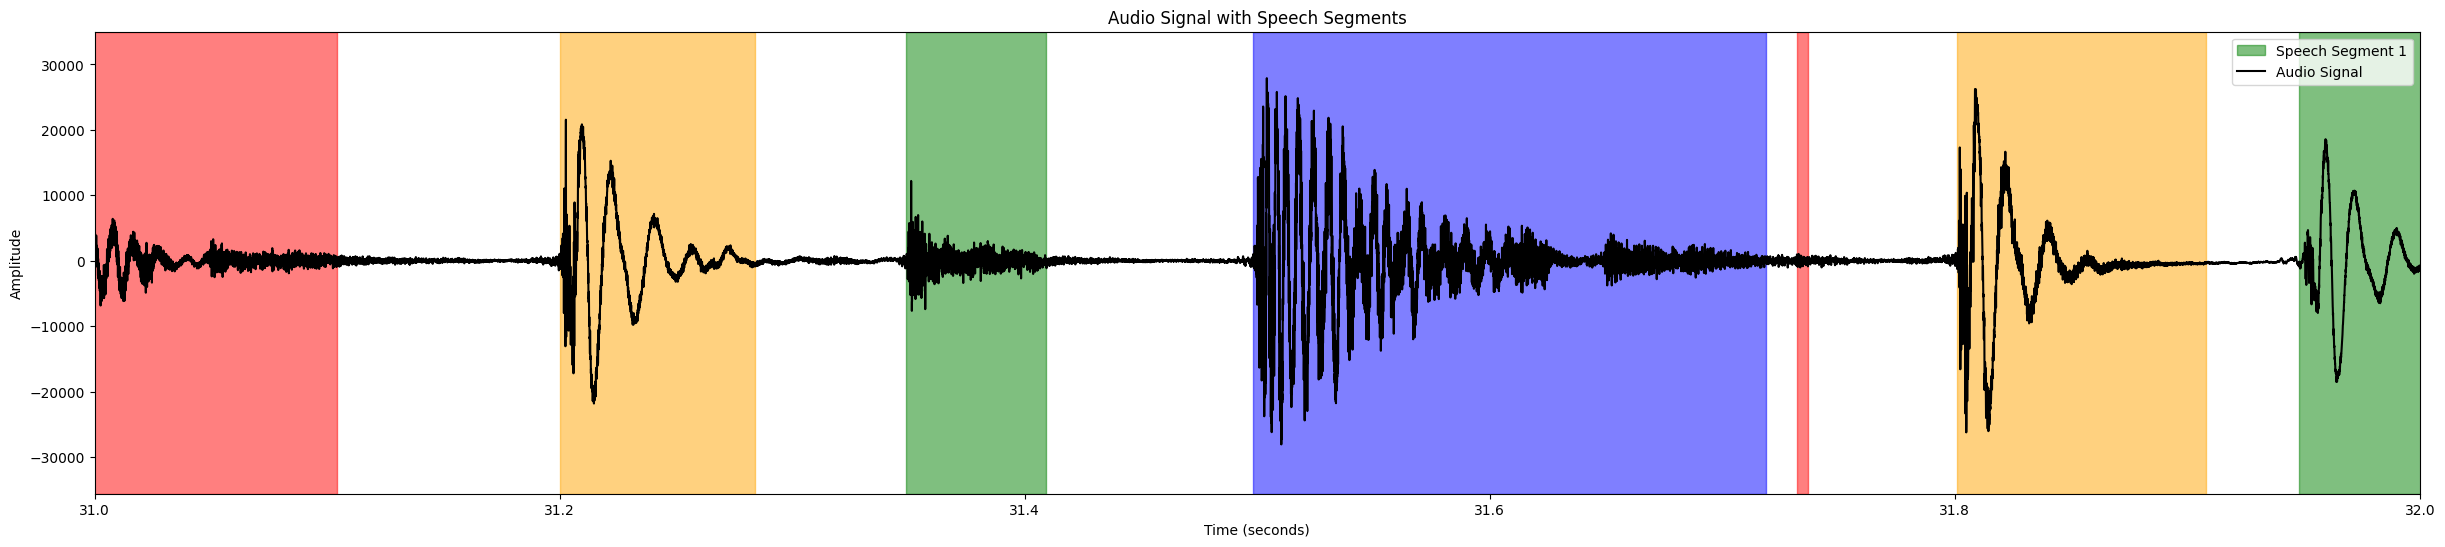

In [4]:
import matplotlib.pyplot as plt

chunk =Rhythm.extract_audio_chunks(Audio,10,-40)
time = np.arange(0, len(AudioArray)) /  Audio.frame_rate

# 플로팅
plt.figure(figsize=(30, 6))

# 색상 리스트 (색상은 필요에 따라 조정)
colors = ['green', 'blue', 'red', 'orange']

# 음성 구간 플로팅 (각 음성 구간마다 다른 색상으로)
for i, (start, end) in enumerate(chunk):
    plt.axvspan(start, end, color=colors[i % len(colors)], alpha=0.5, label=f'Speech Segment {i+1}' if i == 0 else "")

# 오디오 신호 플로팅
plt.plot(time,AudioArray, label='Audio Signal', color='black')

# 레이블 설정
plt.title('Audio Signal with Speech Segments')
plt.xlim(31, 32)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.show()


Silence Detection이 원하는 방향으로 수행되지 않은 부분(약 31.7) 을 확인할 수 있다.  
이상치를 제거한다.

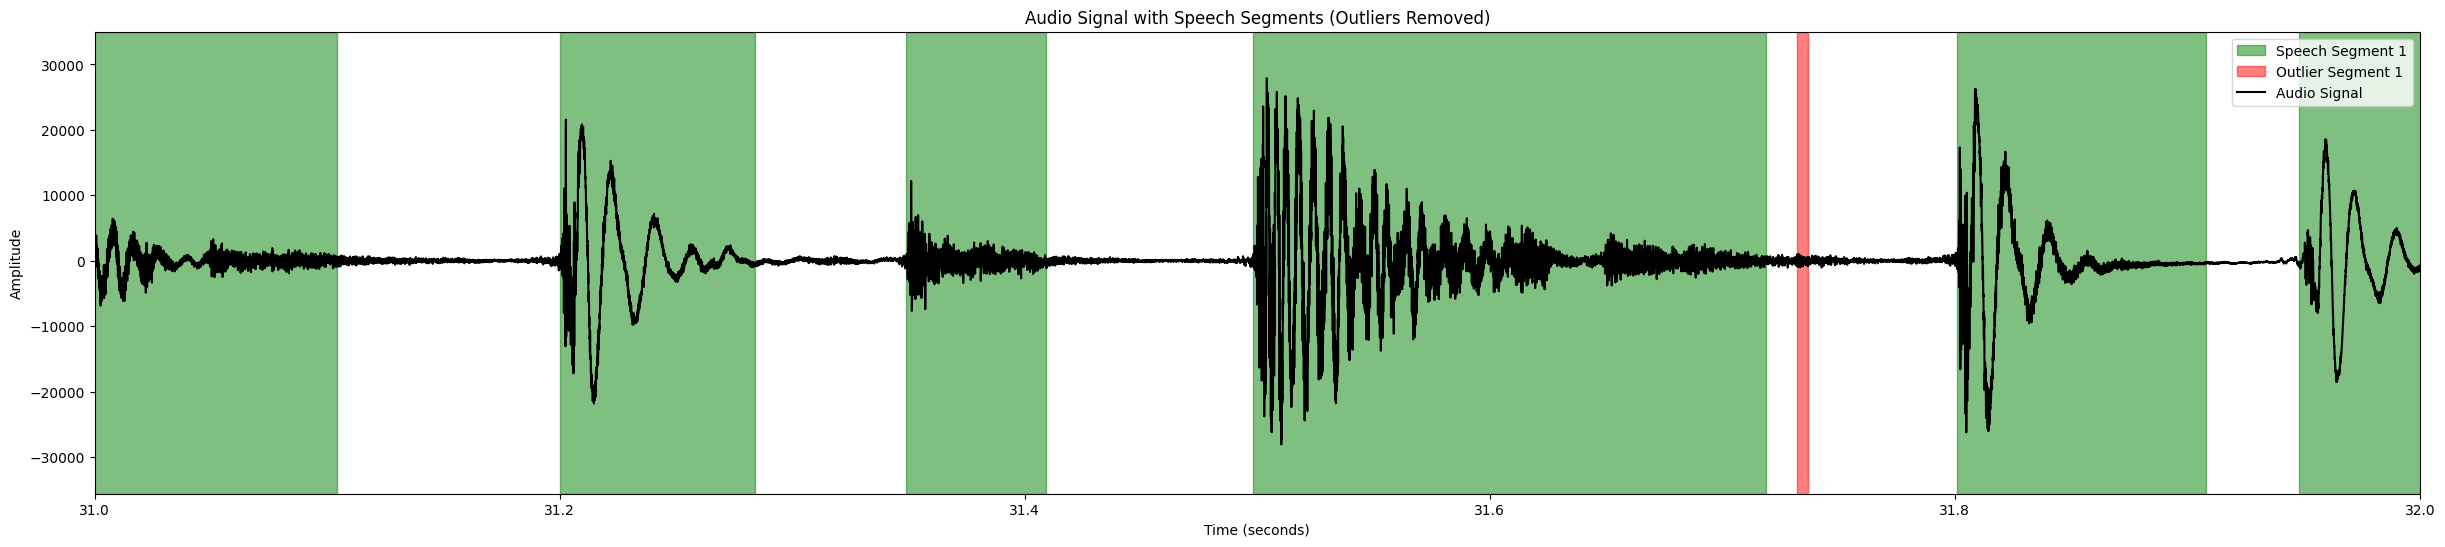

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 각 청크의 지속시간 구하기
durations = np.array([end - start for start, end in chunk])

threshold_duration =  0.05
filtered_chunks = [chunk[i] for i in range(len(chunk)) if durations[i] >= threshold_duration]
outlier_chunks = [chunk[i] for i in range(len(chunk)) if durations[i] < threshold_duration]

# 시간 계산
time = np.arange(0, len(AudioArray)) / Audio.frame_rate

# 플로팅
plt.figure(figsize=(30, 6))

# 음성 구간 플로팅 (정상 청크)
for i, (start, end) in enumerate(filtered_chunks):
    plt.axvspan(start, end, color='green', alpha=0.5, label=f'Speech Segment {i+1}' if i == 0 else "")

# 음성 구간 플로팅 (이상치 청크)
for i, (start, end) in enumerate(outlier_chunks):
    plt.axvspan(start, end, color='red', alpha=0.5, label=f'Outlier Segment {i+1}' if i == 0 else "")

# 오디오 신호 플로팅
plt.plot(time, AudioArray, label='Audio Signal', color='black')

# 레이블 설정
plt.title('Audio Signal with Speech Segments (Outliers Removed)')
plt.xlim(31, 32)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.show()

이제 각 청크별로 STFT 를 수행하여 
주파수를 찾는다.

In [6]:
from scipy.signal import stft
from collections import Counter
from scipy.stats import norm
n_fft = 512
hop_size = n_fft/4
# 각 청크별로 STFT를 수행하고 주파수를 추출
frequencies = []
times = []
stft_results = []
dominant_frequencies = []
for start, end in chunk:
    # 청크의 오디오 데이터를 추출
    chunk_data = AudioArray[int(start * Audio.frame_rate):int(end * Audio.frame_rate)]
    duration = end - start  # 시간 차이로 길이 계산
    # 청크 시간이 최소 시간보다 짧으면 SILENCE 추가 (0 값으로 패딩)
    min_duration = 1
    if duration < min_duration:
        # SILENCE 추가할 길이 계산 (최소 시간에서 현재 시간 차이를 빼면 됨)
        silence_duration = min_duration - duration
        silence_samples = int(silence_duration * Audio.frame_rate)  # SILENCE를 샘플 단위로 변환
        silence = np.zeros(silence_samples)  # SILENCE 데이터 생성
        # 청크 데이터 뒤에 SILENCE 추가
        chunk_data = np.concatenate([chunk_data, silence])
    f, t, Zxx = stft(chunk_data, fs=Audio.frame_rate, nperseg=n_fft, noverlap=hop_size)
    # 전체 시간 구간에 대해 가장 큰 진폭을 가진 주파수 찾기
    magnitude = np.abs(Zxx)  # 전체 시간 구간에 대한 진폭 크기
    max_index = np.argmax(np.sum(magnitude, axis=1))  # 진폭을 시간 축을 따라 합산 후 가장 큰 값의 인덱스 찾기
    dominant_frequencies.append(f[max_index])  # 해당 인덱스의 주파수 값 추가
    # STFT 결과 저장
    stft_results.append(Zxx)
    frequencies.append(f)
    times.append(t)

# 자주 나타나는 주파수 찾기
frequency_counts = Counter(dominant_frequencies)

# 등장 횟수 배열
counts = np.array(list(frequency_counts.values()))

# 평균과 표준편차 계산
mean_count = np.mean(counts)
std_dev_count = np.std(counts)

# 유의 수준
alpha = 0.05
z_score_threshold = norm.ppf(1 - alpha / 2)  # 약 1.96

# 경계값 계산
lower_bound = mean_count - z_score_threshold * std_dev_count
upper_bound = mean_count + z_score_threshold * std_dev_count

# 유의미한 주파수 추출
meaningful_frequencies = [
    (freq, count) for freq, count in frequency_counts.items()
    if ((count > upper_bound) | (count < lower_bound))
]

# 결과 출력
print(f"유의미한 주파수 개수: {len(meaningful_frequencies)}")
print("유의미한 주파수 목록:")
for freq, count in meaningful_frequencies:
    print(f"주파수: {freq} Hz, 빈도: {count}")

유의미한 주파수 개수: 3
유의미한 주파수 목록:
주파수: 86.1328125 Hz, 빈도: 114
주파수: 172.265625 Hz, 빈도: 77
주파수: 0.0 Hz, 빈도: 48


유의미한 주파수들을 가지고  
BandPassFilter 를 적용하여 신호를 증폭 시킨다.

In [7]:
# === 주파수 필터 적용 ===
Filtered_AudioArray = []
for i ,(freq ,count)  in enumerate(meaningful_frequencies):
    sr = Audio.frame_rate
    # 적용 강도
    order = 8
    bandwidth_ratio = 0.1
    low = freq * (1 - bandwidth_ratio)
    high = freq * (1 + bandwidth_ratio)
    if((freq<=0 )| (freq >= sr/2)):
        continue
    low = max(low,1)
    high = min(high,sr/2-1)
    Filtered_AudioArray.append(Rhythm.Butter_filter(AudioArray, sr, low ,high,'band',order))

각 필터링된 신호에서 청크를 다시 계산한다.  
이때 마찬가지로 이상치는 길이 값을 통해 제거한다  
Midi 파일로 저장한다. 

Channels: 1
Sample rate: 44100
Duration: 81.00047619047619
Bit depth: 2 bytes
len samples: 3572121


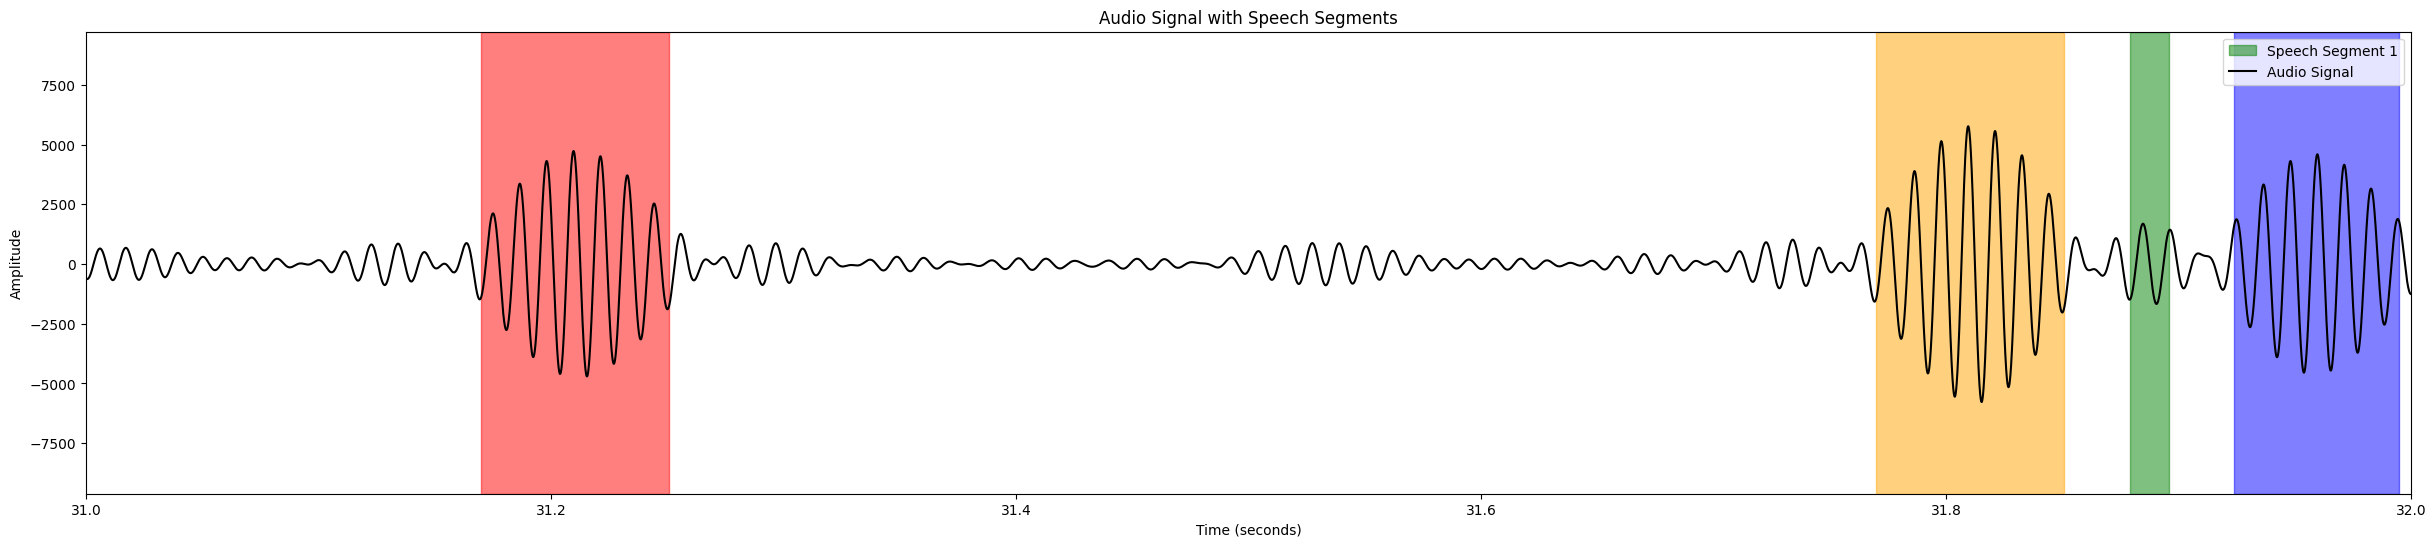

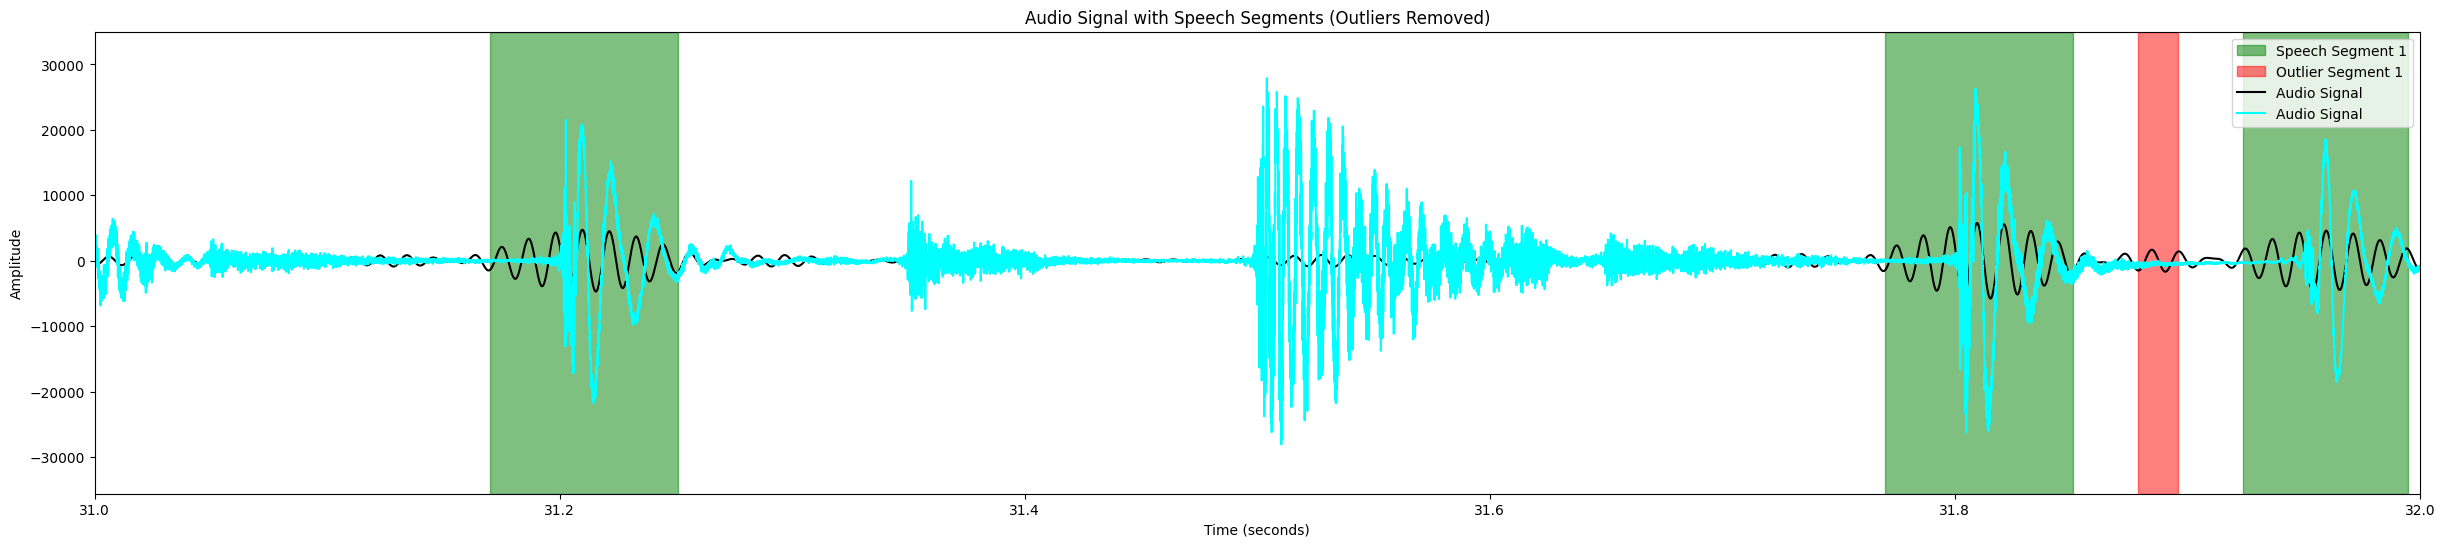

Channels: 1
Sample rate: 44100
Duration: 81.00047619047619
Bit depth: 2 bytes
len samples: 3572121


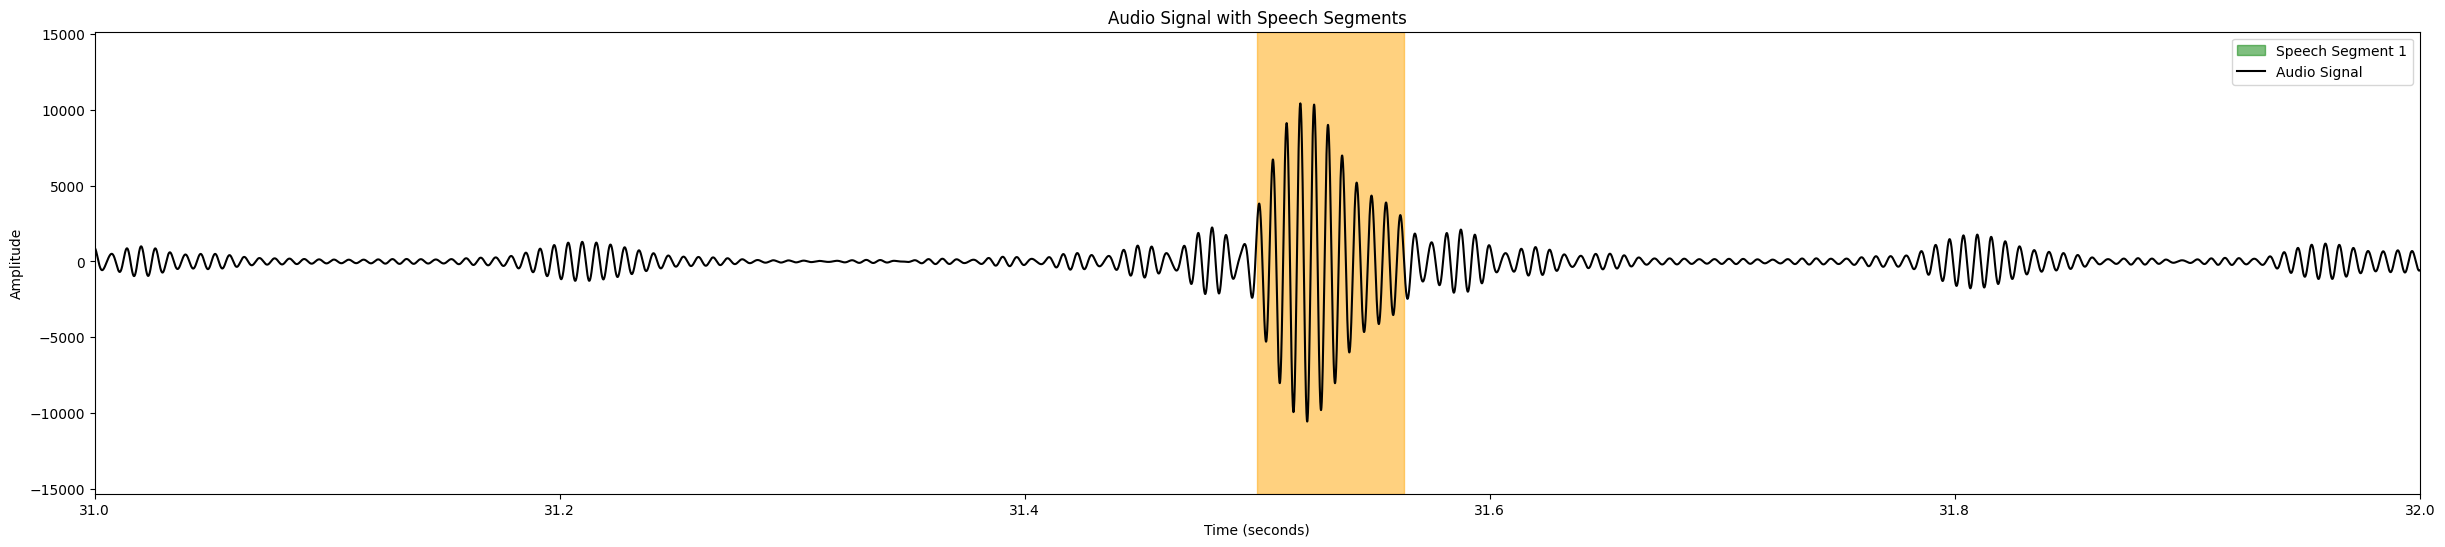

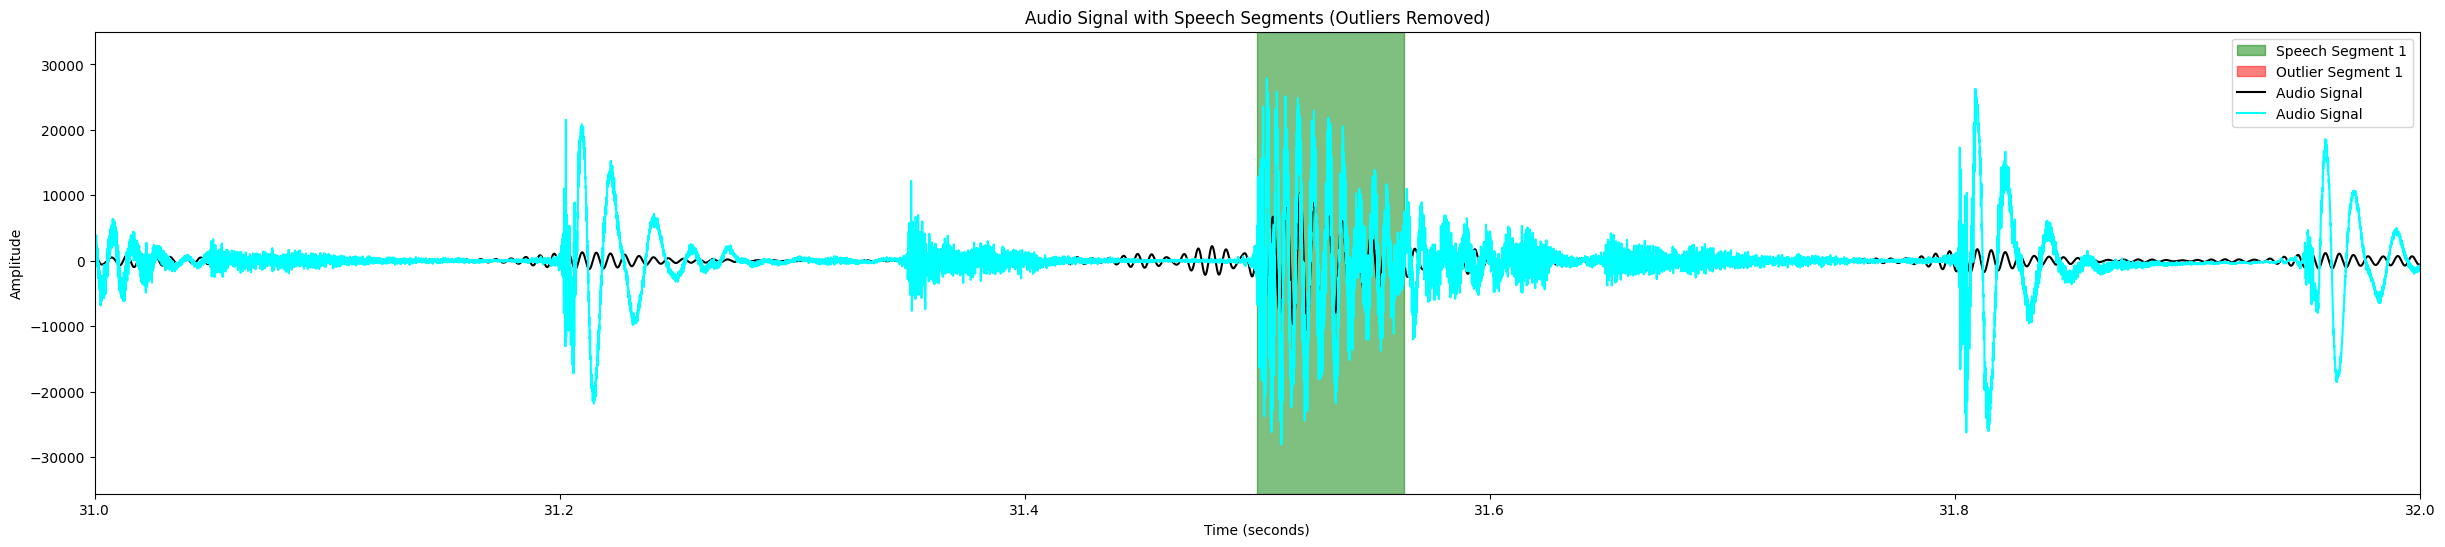

In [8]:
chunks = []
for i ,array in enumerate(Filtered_AudioArray):
    filtered_audio = Rhythm.GetAudio(array,Audio.frame_rate,Audio.sample_width,1)
    Rhythm.PrintAudioInfo(filtered_audio)
    chunk = Rhythm.extract_audio_chunks(filtered_audio,10,-20)
    # 플로팅
    plt.figure(figsize=(30, 6))

    # 색상 리스트 (색상은 필요에 따라 조정)
    colors = ['green', 'blue', 'red', 'orange']

    # 음성 구간 플로팅 (각 음성 구간마다 다른 색상으로)
    for i, (start, end) in enumerate(chunk):
        plt.axvspan(start, end, color=colors[i % len(colors)], alpha=0.5, label=f'Speech Segment {i+1}' if i == 0 else "")


    # 오디오 신호 플로팅
    time = np.arange(0, len(array)) /  Audio.frame_rate
    plt.plot(time,array, label='Audio Signal', color='black')
    
    # 레이블 설정
    plt.title('Audio Signal with Speech Segments')
    plt.xlim(31, 32)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.show()

    # 각 청크의 지속시간 구하기
    durations = np.array([end - start for start, end in chunk])

    threshold_duration =  0.05
    filtered_chunks = [chunk[i] for i in range(len(chunk)) if durations[i] >= threshold_duration]
    outlier_chunks = [chunk[i] for i in range(len(chunk)) if durations[i] < threshold_duration]

    chunks.append(filtered_chunks)

    # 시간 계산
    time = np.arange(0, len(array)) / Audio.frame_rate

    # 플로팅
    plt.figure(figsize=(30, 6))

    # 음성 구간 플로팅 (정상 청크)
    for i, (start, end) in enumerate(filtered_chunks):
        plt.axvspan(start, end, color='green', alpha=0.5, label=f'Speech Segment {i+1}' if i == 0 else "")

    # 음성 구간 플로팅 (이상치 청크)
    for i, (start, end) in enumerate(outlier_chunks):
        plt.axvspan(start, end, color='red', alpha=0.5, label=f'Outlier Segment {i+1}' if i == 0 else "")

    # 오디오 신호 플로팅
    plt.plot(time, array, label='Audio Signal', color='black')

    time = np.arange(0, len(AudioArray)) / Audio.frame_rate
    plt.plot(time, AudioArray, label='Audio Signal', color='cyan')

    # 레이블 설정
    plt.title('Audio Signal with Speech Segments (Outliers Removed)')
    plt.xlim(31, 32)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.show()


주파수 필터를 거쳐서 잘라낸 Chunk 와 원 신호를 비교할때 (31.2)의 경우와 같이  
Silent 구간이 보임으로 원본을 기준으로 수정한다

In [9]:
import librosa
finalchunks = []
for i ,chunk  in enumerate(chunks):
    newChunk = []
    for j ,(start, end) in enumerate(chunk):
        segment = Audio[start*1000:end*1000]
        # 음성의 실제 시작과 끝 감지
        onset_sample, offset_sample = Rhythm.detect_onset_trim(segment, sr,3,-40)
        # 감지 실패 시 그대로 유지
        if onset_sample is None or offset_sample is None:
            newChunk.append((start, end))
            continue
        # 새로운 시간 (초 단위)으로 변환
        start_sample = int(start * sr)
        end_sample = int(end * sr)
        new_start = (start_sample + onset_sample) / sr
        new_end = (start_sample +  offset_sample) / sr
        newChunk.append((new_start, new_end))
    finalchunks.append(newChunk)


최종적으로 찾아낸 Chunk를 시각화

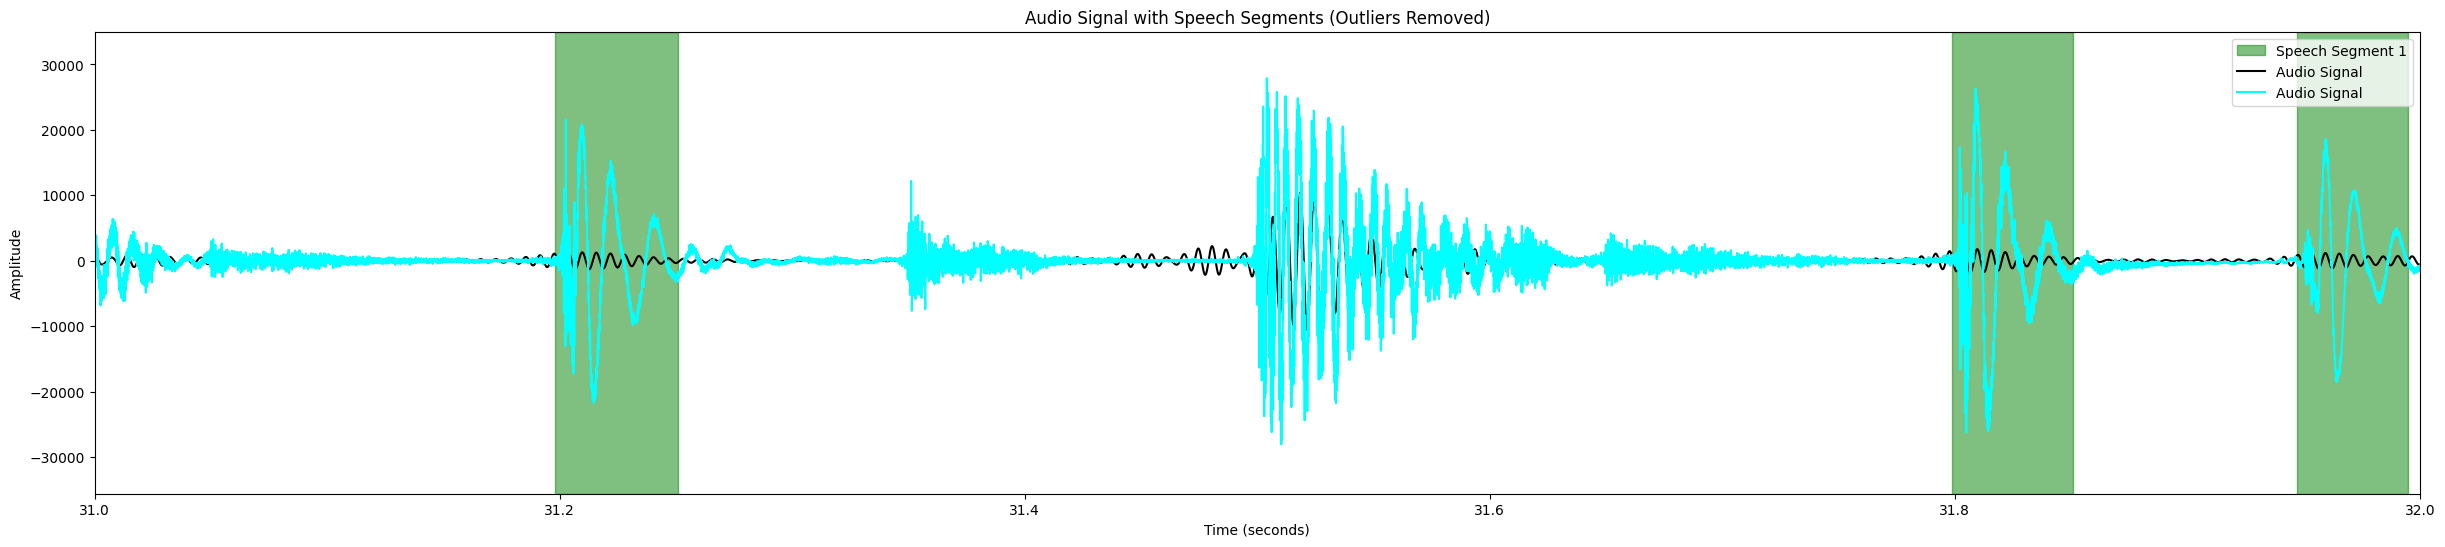

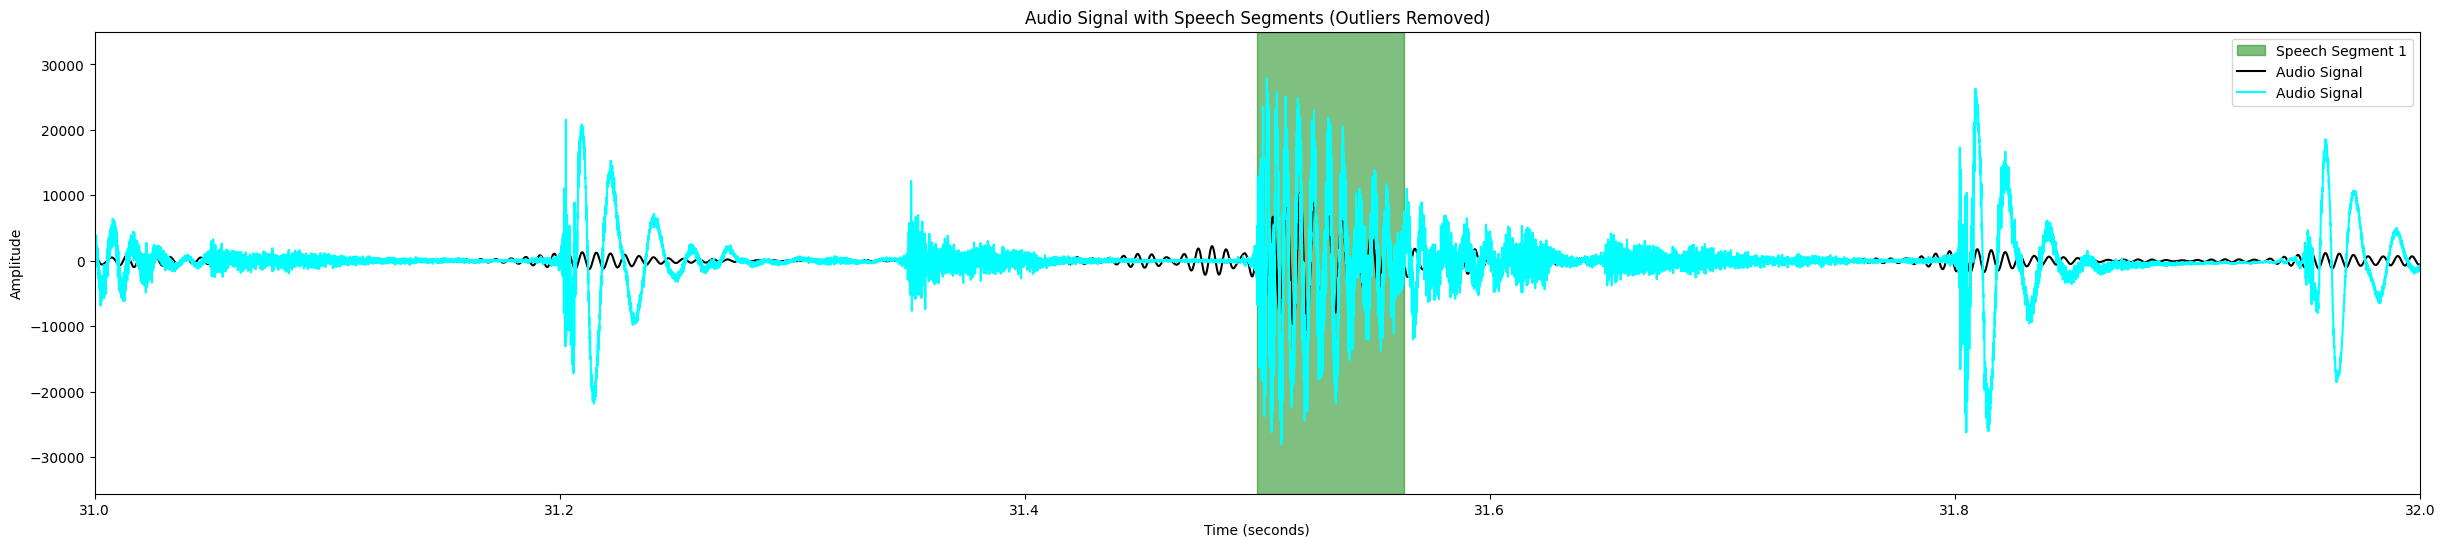

In [10]:
for i ,chunk  in enumerate(finalchunks):
    # 플로팅
    plt.figure(figsize=(30, 6))
    # 음성 구간 플로팅 (각 음성 구간마다 다른 색상으로)
    for i, (start, end) in enumerate(chunk):
        plt.axvspan(start, end, color='green', alpha=0.5, label=f'Speech Segment {i+1}' if i == 0 else "")

    # 오디오 신호 플로팅
    plt.plot(time, array, label='Audio Signal', color='black')

    time = np.arange(0, len(AudioArray)) / Audio.frame_rate
    plt.plot(time, AudioArray, label='Audio Signal', color='cyan')

    # 레이블 설정
    plt.title('Audio Signal with Speech Segments (Outliers Removed)')
    plt.xlim(31, 32)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.show()

In [11]:
!pip install pretty_midi

In [12]:
import pretty_midi
import numpy as np

def freq_to_midi_pitch(freq):
    return int(69 + 12 * np.log2(freq / 440.0))

midi = pretty_midi.PrettyMIDI(initial_tempo = tempo)
drum_channels = []
for i ,chunk  in enumerate(finalchunks):
    freq = meaningful_frequencies[i][0]
    pitch = freq_to_midi_pitch(freq) 
    new_instr = pretty_midi.Instrument(program=0, is_drum=True)
    drum_channels.append(new_instr)
    for j ,(start, end)  in enumerate(chunk):
        note = pretty_midi.Note(
            velocity=100,
            pitch= pitch,
            start=start,
            end= end
        )
        new_instr.notes.append(note)

for instr in drum_channels:
    midi.instruments.append(instr)

# 저장
midi_file = "drum_pattern.mid"
midi.write(midi_file)
print(f"MIDI 파일이 '{midi_file}'로 저장되었습니다.")

MIDI 파일이 'drum_pattern.mid'로 저장되었습니다.


In [13]:
import json
song_data = {
    "title": path,  
    "tempo": tempo,           
    "notes": {}  
}

for i, chunk in enumerate(finalchunks):
    freq = meaningful_frequencies[i][0]

    if str(pitch) not in song_data["notes"]:
        song_data["notes"][str(freq)] = []

    for start, end in chunk:
        song_data["notes"][str(freq)].append({
            "start": start,
            "end": end
        })

# JSON 저장
json_file = "drum_notes.json"
with open(json_file, "w") as f:
    json.dump(song_data, f, indent=4)

print(f"JSON 파일이 '{json_file}'로 저장되었습니다.")


JSON 파일이 'drum_notes.json'로 저장되었습니다.
